In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import seaborn as sns
import matplotlib.pyplot as plt

In [31]:
cat_df=pd.read_csv('Données_communes/Catalogue.csv',encoding='latin-1')
cat_df.head()

,marque,nom,puissance,longueur,nbPlaces,nbPortes,couleur,occasion,prix
0,Volvo,S80 T6,272,très longue,5,5,blanc,False,50500
1,Volvo,S80 T6,272,très longue,5,5,noir,False,50500
2,Volvo,S80 T6,272,très longue,5,5,rouge,False,50500
3,Volvo,S80 T6,272,très longue,5,5,gris,True,35350
4,Volvo,S80 T6,272,très longue,5,5,bleu,True,35350


### Exploration de données

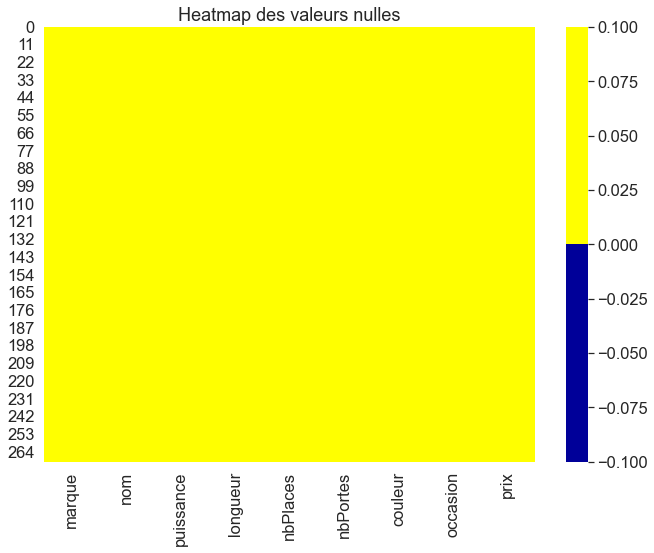

In [32]:
colours = ['#000099', '#ffff00'] 
sns.heatmap(cat_df.isnull(),cmap=sns.color_palette(colours))
plt.title('Heatmap des valeurs nulles')
plt.show()


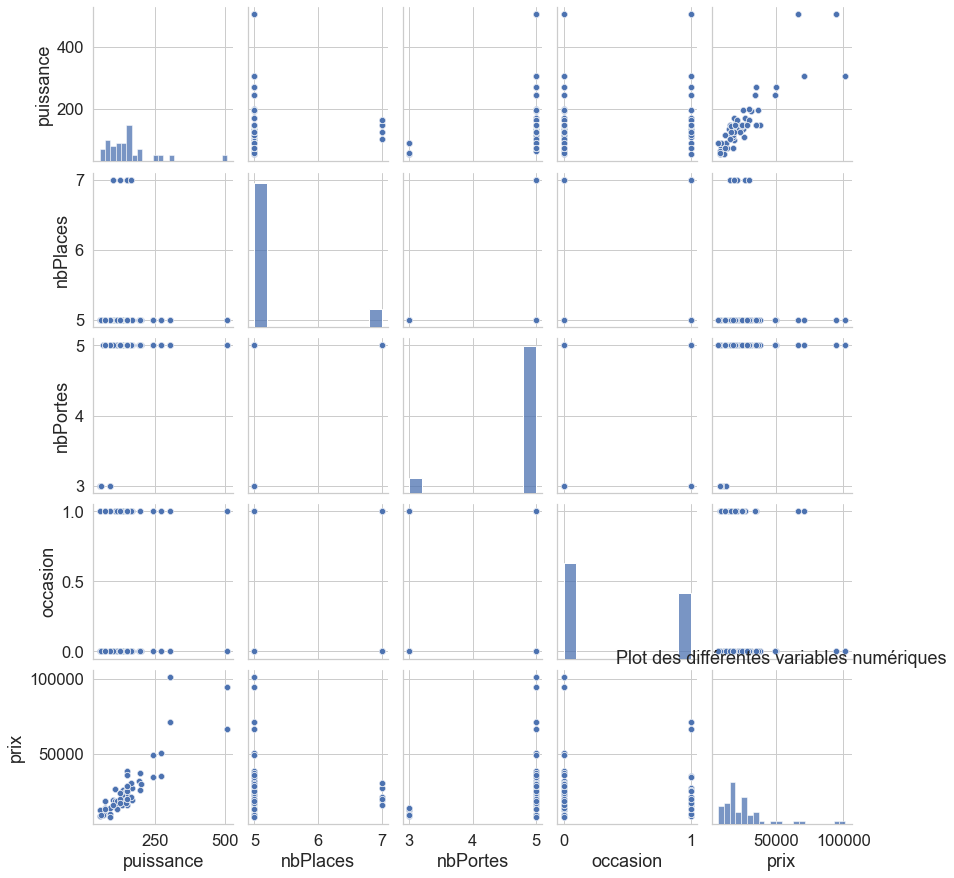

In [33]:
cat_df.occasion = cat_df.occasion.replace({True: 1, False: 0})
sns.pairplot(cat_df)
plt.title('Plot des différentes variables numériques')
plt.show()

D'apres les résultats ci-dessus, on peut en déduire que:
- Il y a une corrélation linéaire entre la puissance et le prix.
- Les voitures neuves on tendance à etre plus chère.
- Les voitures à 3 portes sont beaucoup moins chères que les voitures à 5 portes
- Les voitures à 7 places sont plus rares que les voitures à 5 places

On peut penser à catégoriser les voitures selon leurs nombre de portes, de places et leurs puissances/prix.

## Etude des variables catégorielles

In [34]:
cat_df.describe(include=object)

,marque,nom,longueur,couleur
count,270,270,270,270
unique,21,32,4,5
top,Renault,S80 T6,longue,blanc
freq,40,10,90,54


In [35]:
cat_df=cat_df.drop(columns='couleur')

In [36]:
cat_df.marque.value_counts()

Renault       40
Volkswagen    40
Audi          20
Mercedes      20
BMW           20
Nissan        15
Fiat          10
Ford          10
Jaguar        10
Volvo         10
Mini          10
Peugeot       10
Saab          10
Lancia        10
Kia            5
Hyundaï        5
Honda          5
Seat           5
Daihatsu       5
Dacia          5
Skoda          5
Name: marque, dtype: int64

Text(0.5, 1.0, 'Distribution des prix par rapport aux marques')

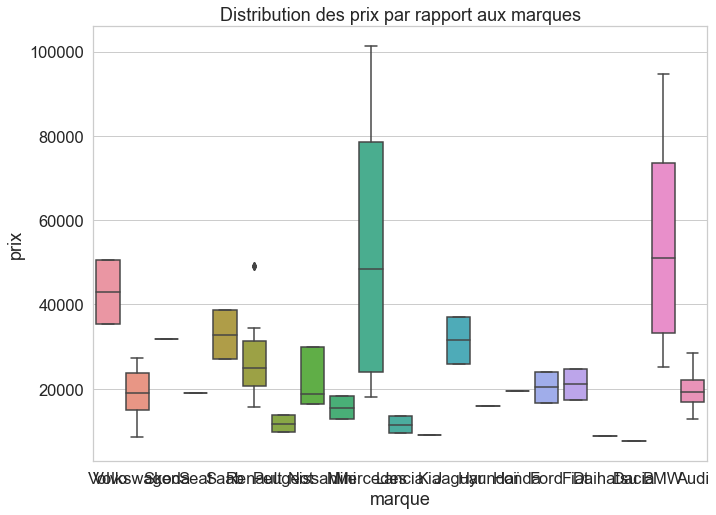

In [37]:
sns.set(rc={'figure.figsize':(11,8)}, font_scale=1.5, style='whitegrid')

sns.boxplot(x=cat_df['marque'],y=cat_df['prix'])
plt.title('Distribution des prix par rapport aux marques')

Text(0.5, 1.0, 'Distribution des prix par rapport aux noms')

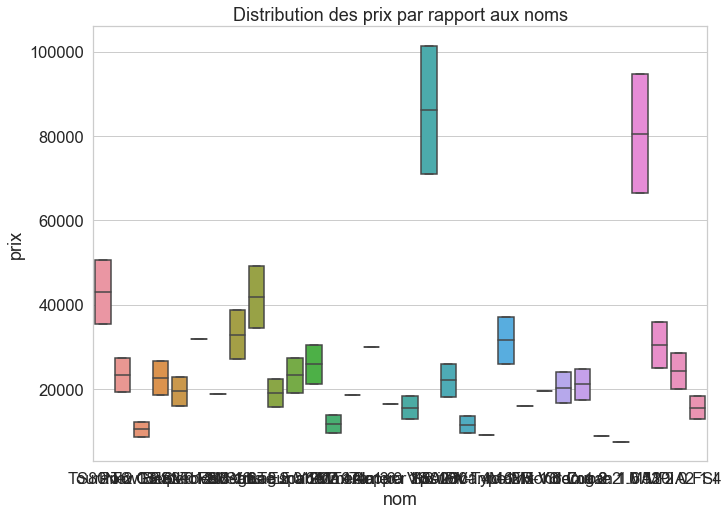

In [38]:
sns.set(rc={'figure.figsize':(11,8)}, font_scale=1.5, style='whitegrid')

sns.boxplot(x=cat_df['nom'],y=cat_df['prix'])
plt.title('Distribution des prix par rapport aux noms')

On peut remarquer une distribution plus ou moins similaire entre ces deux variables, pour le reste de notre travail, on choisit de les fusionner en une seule variable.

In [39]:
cat_df['full_name']=cat_df.marque+'_'+cat_df.nom
cat_df=cat_df.drop(columns=['marque','nom'])
cat_df

,puissance,longueur,nbPlaces,nbPortes,occasion,prix,full_name
0,272,très longue,5,5,0,50500,Volvo_S80 T6
1,272,très longue,5,5,0,50500,Volvo_S80 T6
2,272,très longue,5,5,0,50500,Volvo_S80 T6
3,272,très longue,5,5,1,35350,Volvo_S80 T6
4,272,très longue,5,5,1,35350,Volvo_S80 T6
...,...,...,...,...,...,...,...
265,75,courte,5,5,0,18310,Audi_A2 1.4
266,75,courte,5,5,0,18310,Audi_A2 1.4
267,75,courte,5,5,1,12817,Audi_A2 1.4
268,75,courte,5,5,1,12817,Audi_A2 1.4


## Analyse bivariée des variables catégorielles

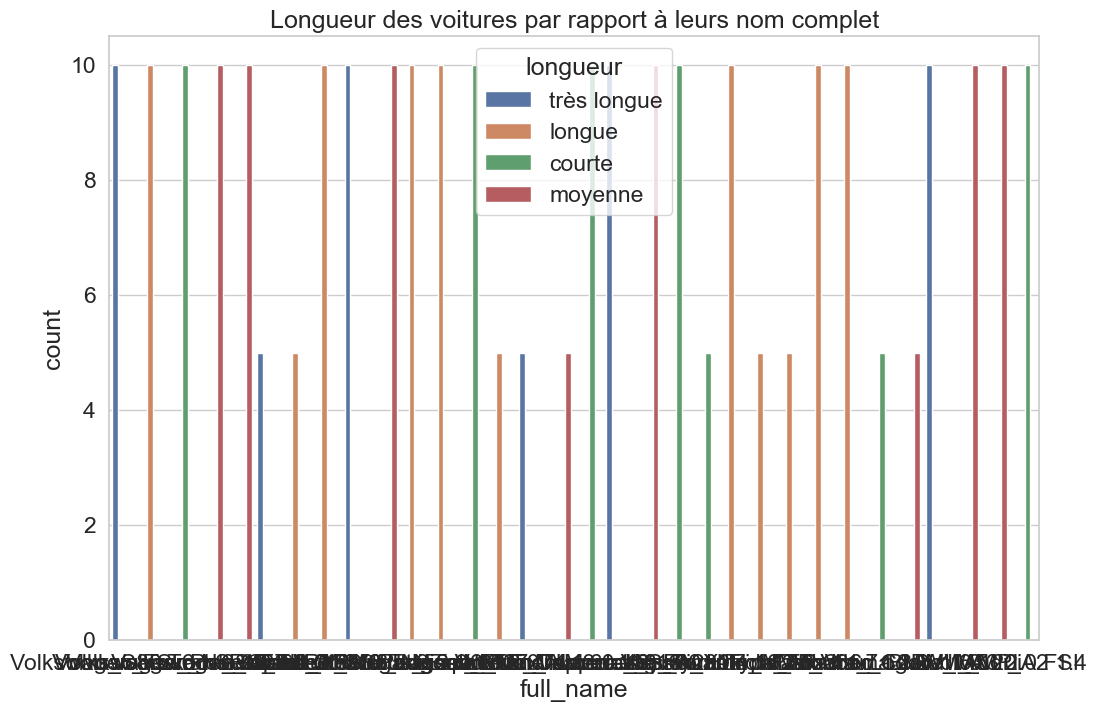

In [42]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
sns.countplot(x=cat_df.full_name,hue=cat_df.longueur, )
plt.title('Longueur des voitures par rapport à leurs nom complet')
plt.show()


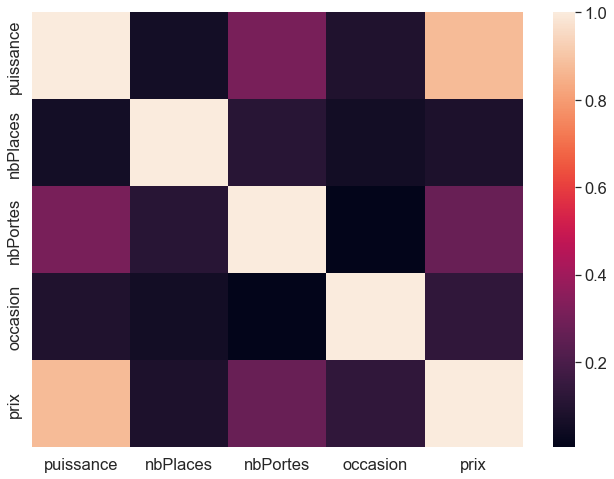

In [43]:
g = sns.heatmap(cat_df.corr().abs())

Suite à ces analyses, on va retenir les variables Marque, Longueur, Prix, NbPlaces, nbPortes, occasion et puissance pour faire le clustering des voitures.

## Processing et clustering

In [107]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [45]:
cat_df.columns

Index(['puissance', 'longueur', 'nbPlaces', 'nbPortes', 'occasion', 'prix',
       'full_name'],
      dtype='object')

In [46]:
categorical=['longueur','occasion','full_name']
numeric_features=['puissance','nbPlaces','nbPortes','prix']

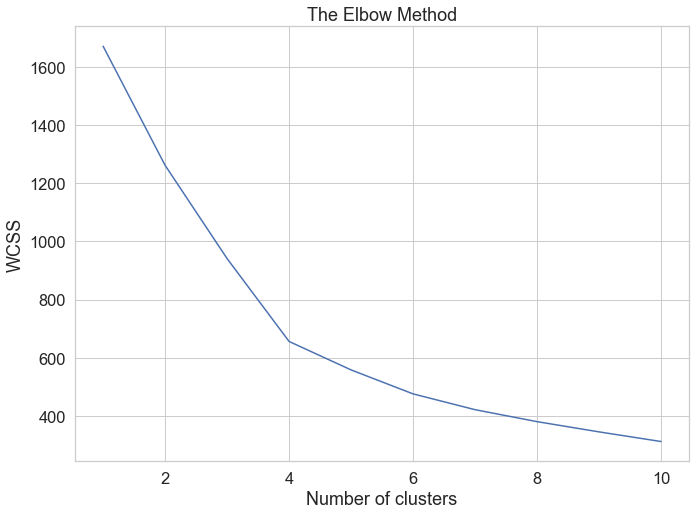

In [47]:
# elbow Method
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])
label=['citadine','routiere','sportive','SUV','familiale']
wcss=[]
for i in range (1,11):
    pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('Kmeans', KMeans(n_clusters=i,init='k-means++', max_iter=100, random_state=0))
    ])
    model=pipeline.fit(cat_df)
    wcss.append(model.named_steps['Kmeans'].inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [48]:
from sklearn import preprocessing
cat_dfe=pd.get_dummies(data=cat_df, columns=categorical)
dfe=preprocessing.MinMaxScaler().fit_transform(cat_dfe)
scaled_features_df = pd.DataFrame(dfe, index=cat_dfe.index, columns=cat_dfe.columns)

scaled_features_df

,puissance,nbPlaces,nbPortes,prix,longueur_courte,longueur_longue,longueur_moyenne,longueur_très longue,occasion_0,occasion_1,...,full_name_Renault_Megane 2.0 16V,full_name_Renault_Vel Satis 3.5 V6,full_name_Saab_9.3 1.8T,full_name_Seat_Toledo 1.6,full_name_Skoda_Superb 2.8 V6,full_name_Volkswagen_Golf 2.0 FSI,full_name_Volkswagen_New Beatle 1.8,full_name_Volkswagen_Polo 1.2 6V,full_name_Volkswagen_Touran 2.0 FSI,full_name_Volvo_S80 T6
0,0.480088,0.0,1.0,0.458422,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.480088,0.0,1.0,0.458422,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.480088,0.0,1.0,0.458422,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.480088,0.0,1.0,0.296908,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.480088,0.0,1.0,0.296908,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,0.044248,0.0,1.0,0.115245,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
266,0.044248,0.0,1.0,0.115245,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
267,0.044248,0.0,1.0,0.056684,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
268,0.044248,0.0,1.0,0.056684,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


c:\Users\UserAD\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Silhouette score for k(clusters) = 3 is 0.2112214760310312
Silhouette score for k(clusters) = 4 is 0.27425105561519425


c:\Users\UserAD\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\UserAD\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Silhouette score for k(clusters) = 5 is 0.2571806947062632
Silhouette score for k(clusters) = 6 is 0.27431569663296085


c:\Users\UserAD\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\UserAD\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Silhouette score for k(clusters) = 7 is 0.29899870621998287
Silhouette score for k(clusters) = 8 is 0.31629903723346325


c:\Users\UserAD\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\UserAD\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Silhouette score for k(clusters) = 9 is 0.3245445045617161
Silhouette score for k(clusters) = 10 is 0.33861049576886487


c:\Users\UserAD\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\UserAD\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Silhouette score for k(clusters) = 11 is 0.346492245088493
Silhouette score for k(clusters) = 12 is 0.3363329347700335


c:\Users\UserAD\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


<AxesSubplot:xlabel='Clusters', ylabel='Sil Score'>

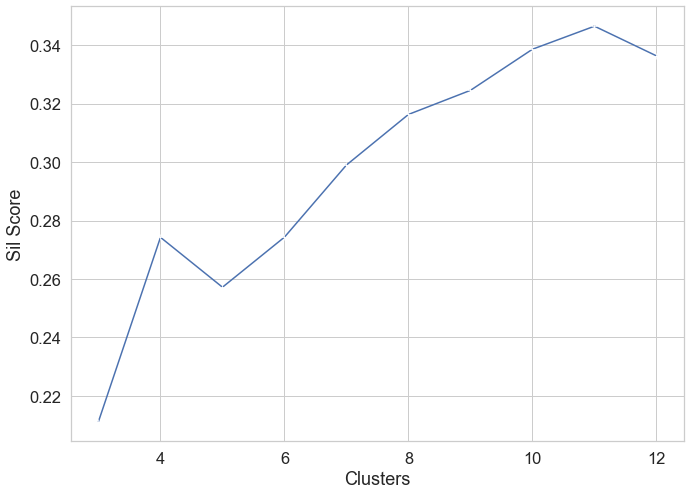

In [49]:
import sklearn.cluster as cluster
import sklearn.metrics as metrics
SK = range(3,13)
sil_score = []
for i in SK:
    labels=cluster.KMeans(n_clusters=i,init="k-means++",random_state=200).fit(scaled_features_df).labels_
    score = metrics.silhouette_score(scaled_features_df,labels,metric="euclidean",sample_size=1000,random_state=200)
    sil_score.append(score)
    print ("Silhouette score for k(clusters) = "+str(i)+" is "
           +str(metrics.silhouette_score(scaled_features_df,labels,metric="euclidean",sample_size=1000,random_state=200)))
sil_centers = pd.DataFrame({'Clusters' : SK, 'Sil Score' : sil_score})
sil_centers     
sns.lineplot(x = 'Clusters', y = 'Sil Score', data = sil_centers, marker="+")      

D'apres ces deux méthodes ci-dessus, on retiendra le nombre de cluster à 4 pour le k-means.

{'icoord': [[35.0, 35.0, 45.0, 45.0],
  [25.0, 25.0, 40.0, 40.0],
  [15.0, 15.0, 32.5, 32.5],
  [5.0, 5.0, 23.75, 23.75],
  [85.0, 85.0, 95.0, 95.0],
  [75.0, 75.0, 90.0, 90.0],
  [65.0, 65.0, 82.5, 82.5],
  [55.0, 55.0, 73.75, 73.75],
  [14.375, 14.375, 64.375, 64.375],
  [135.0, 135.0, 145.0, 145.0],
  [125.0, 125.0, 140.0, 140.0],
  [115.0, 115.0, 132.5, 132.5],
  [105.0, 105.0, 123.75, 123.75],
  [185.0, 185.0, 195.0, 195.0],
  [175.0, 175.0, 190.0, 190.0],
  [165.0, 165.0, 182.5, 182.5],
  [155.0, 155.0, 173.75, 173.75],
  [114.375, 114.375, 164.375, 164.375],
  [235.0, 235.0, 245.0, 245.0],
  [225.0, 225.0, 240.0, 240.0],
  [215.0, 215.0, 232.5, 232.5],
  [205.0, 205.0, 223.75, 223.75],
  [285.0, 285.0, 295.0, 295.0],
  [275.0, 275.0, 290.0, 290.0],
  [265.0, 265.0, 282.5, 282.5],
  [255.0, 255.0, 273.75, 273.75],
  [214.375, 214.375, 264.375, 264.375],
  [139.375, 139.375, 239.375, 239.375],
  [39.375, 39.375, 189.375, 189.375],
  [335.0, 335.0, 345.0, 345.0],
  [325.0, 325.0, 3

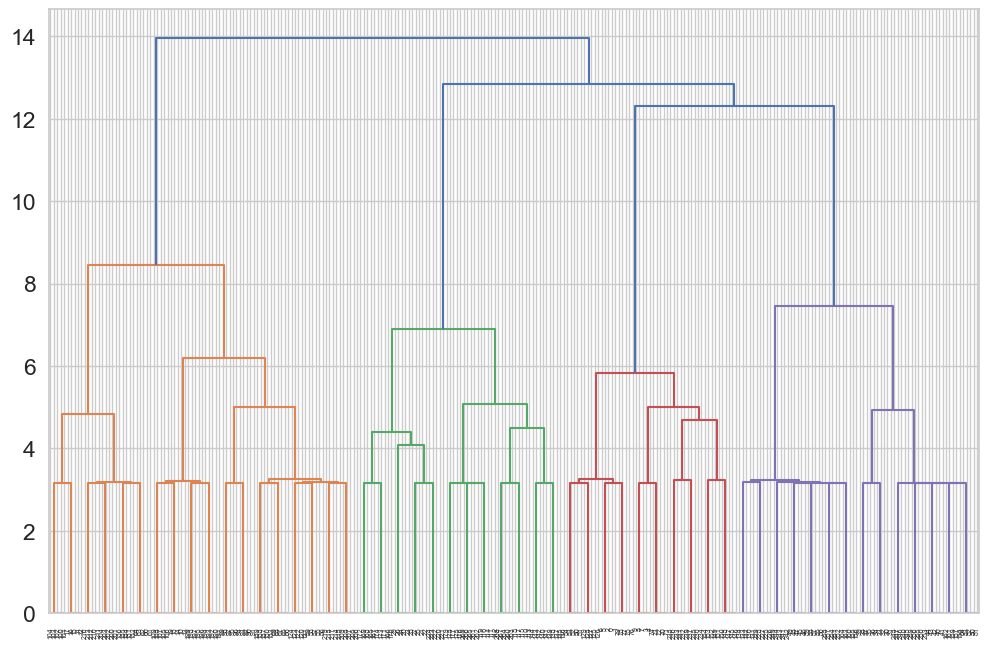

In [50]:
import scipy.cluster.hierarchy as shc
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')

dend=shc.dendrogram(shc.linkage(scaled_features_df,method='ward'))
display(dend)

Le dendrogramme affiche clairement 4 clusters principaux, tout comme le nombre de clusters qu'on va choisir pour le k-means.

In [92]:
cat_df.columns

Index(['puissance', 'longueur', 'nbPlaces', 'nbPortes', 'occasion', 'prix',
       'full_name', 'categorie'],
      dtype='object')

In [95]:
def visualize_clusters(df, num_clusters,title,kmeans):
    colors = ['b', 'g', 'r', 'c']
    
    for n in range(num_clusters):
        clustered_df = df[df['cluster'] == n]
        plt.scatter(clustered_df['puissance'], clustered_df['prix'], c=colors[n-1])
        plt.xlabel('puissance', fontsize=13)
        plt.ylabel('prix', fontsize=13)
        plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],color='purple',marker='*',label='centroid')

    plt.title(title)
    plt.show()

c:\Users\UserAD\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


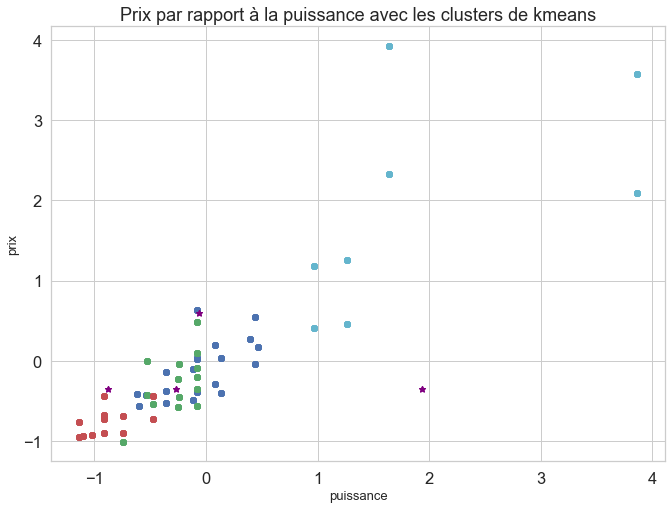

In [96]:
cat_dfe=pd.get_dummies(data=cat_df[['puissance', 'longueur', 'nbPlaces', 'nbPortes', 'occasion', 'prix','full_name']], columns=categorical)
dfe=preprocessing.StandardScaler().fit_transform(cat_dfe)
scaled_features_df = pd.DataFrame(dfe, index=cat_dfe.index, columns=cat_dfe.columns)
kmeans=KMeans(n_clusters=4, max_iter=100, random_state=0)
kmeans.fit(scaled_features_df)
scaled_features_df['cluster']=kmeans.labels_
visualize_clusters(scaled_features_df, 4,'Prix par rapport à la puissance avec les clusters de kmeans',kmeans)


In [54]:
dfe=preprocessing.StandardScaler().fit_transform(cat_dfe)
scaled_features_df = pd.DataFrame(dfe, index=cat_dfe.index, columns=cat_dfe.columns)

In [55]:
scaled_features_df.shape

(270, 42)

## Visualisation par pca

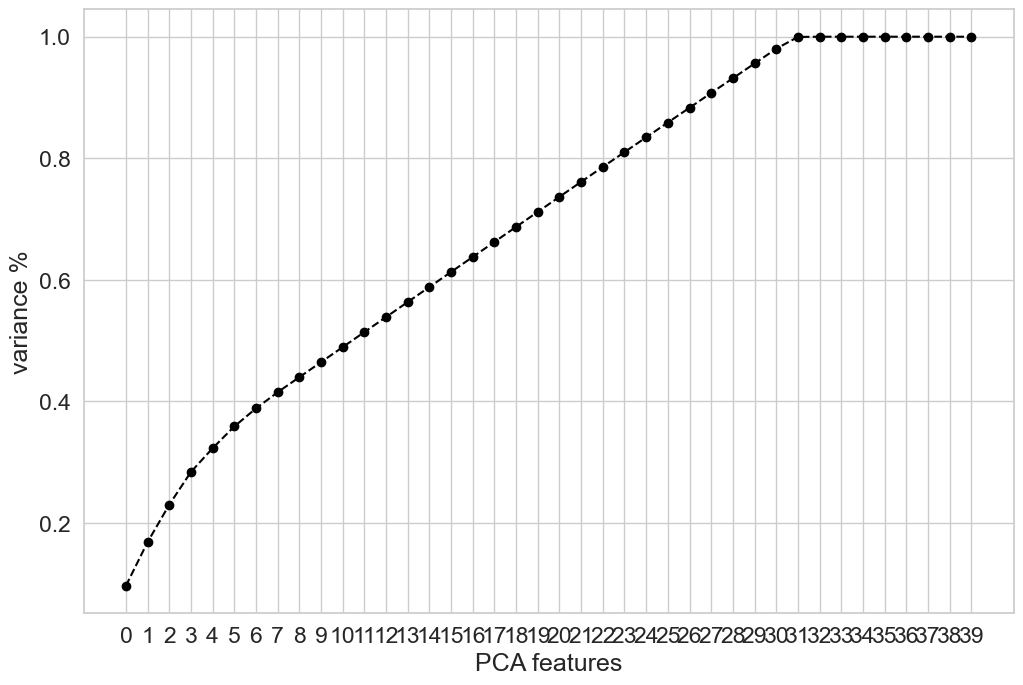

In [63]:
from sklearn.decomposition import PCA

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')

pca = PCA(n_components=40)
principalComponents = pca.fit_transform(scaled_features_df)
# Plot the explained variances
features = range(pca.n_components_)
plt.plot(features, pca.explained_variance_ratio_.cumsum(),marker='o',linestyle='--' ,color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

Une approche du choix du nombre de composantes serait de prendre le nombre ou il y a 80% de la variance de nos données. Dans ce cas là, ca serait 23 composantes.
Celà dit ce nombre est considérable, et nous envisageons d'utiliser la pca seulement pour la visualisation de nos clusters. Nous allons essayer une autre approche ci dessous.

([<matplotlib.axis.XTick at 0x1f48b544430>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

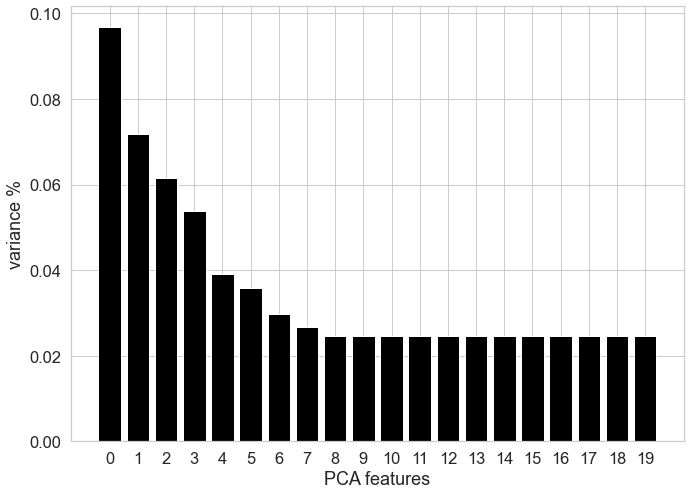

In [64]:
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(scaled_features_df)
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_,color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

Comme on peut le constater, il y a une diminution considérable de la variance à partire du deuxieme composant, c'est à dire que la majorité de la variance de nos données se trouvent dans ces deux composantes. Nous allons donc les retenir pour réaliser les visualisation de nos clusters.

In [65]:
pca=PCA(n_components=3)
scores_pca = pca.fit_transform(scaled_features_df)
kmeans_pca=KMeans(n_clusters=4,init='k-means++',random_state=42)
kmeans_pca.fit(scores_pca)

c:\Users\UserAD\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


KMeans(n_clusters=4, random_state=42)

In [66]:
df_segm_pca_kmeans=pd.concat([scaled_features_df.reset_index(drop=True),
pd.DataFrame(scores_pca)],axis=1)
df_segm_pca_kmeans.columns.values[-3:] = ['Component 1','Component 2','Component 3']
df_segm_pca_kmeans['Segment k-means PCA'] = kmeans_pca.labels_

In [67]:
df_segm_pca_kmeans.head()

,puissance,nbPlaces,nbPortes,prix,longueur_courte,longueur_longue,longueur_moyenne,longueur_très longue,occasion_0,occasion_1,...,full_name_Skoda_Superb 2.8 V6,full_name_Volkswagen_Golf 2.0 FSI,full_name_Volkswagen_New Beatle 1.8,full_name_Volkswagen_Polo 1.2 6V,full_name_Volkswagen_Touran 2.0 FSI,full_name_Volvo_S80 T6,Component 1,Component 2,Component 3,Segment k-means PCA
0,1.2658,-0.353553,0.319438,1.253336,-0.534522,-0.707107,-0.591608,2.097618,0.829156,-0.829156,...,-0.137361,-0.196116,-0.196116,-0.196116,-0.196116,5.09902,3.046129,-1.087162,-0.898402,2
1,1.2658,-0.353553,0.319438,1.253336,-0.534522,-0.707107,-0.591608,2.097618,0.829156,-0.829156,...,-0.137361,-0.196116,-0.196116,-0.196116,-0.196116,5.09902,3.046129,-1.087162,-0.898402,2
2,1.2658,-0.353553,0.319438,1.253336,-0.534522,-0.707107,-0.591608,2.097618,0.829156,-0.829156,...,-0.137361,-0.196116,-0.196116,-0.196116,-0.196116,5.09902,3.046129,-1.087162,-0.898402,2
3,1.2658,-0.353553,0.319438,0.456589,-0.534522,-0.707107,-0.591608,2.097618,-1.206045,1.206045,...,-0.137361,-0.196116,-0.196116,-0.196116,-0.196116,5.09902,2.693836,-1.313119,-0.368951,2
4,1.2658,-0.353553,0.319438,0.456589,-0.534522,-0.707107,-0.591608,2.097618,-1.206045,1.206045,...,-0.137361,-0.196116,-0.196116,-0.196116,-0.196116,5.09902,2.693836,-1.313119,-0.368951,2


c:\Users\UserAD\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Component 2', ylabel='Component 1'>

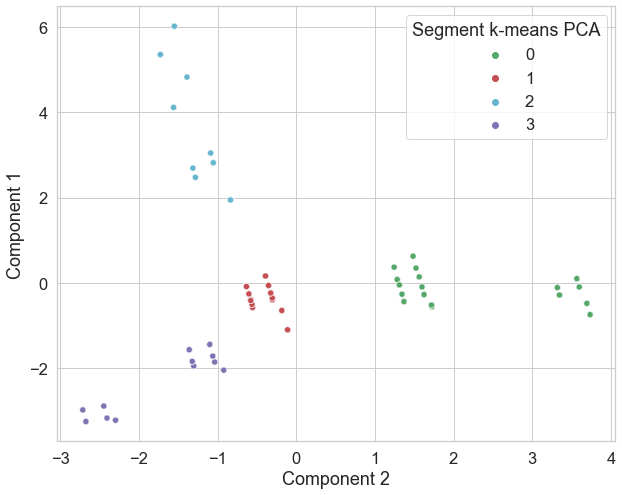

In [68]:
x_axis = df_segm_pca_kmeans['Component 2']
y_axis = df_segm_pca_kmeans['Component 1']
plt.figure(figsize =(10,8))
sns.scatterplot(x_axis,y_axis, hue= df_segm_pca_kmeans['Segment k-means PCA'],
palette=['g','r','c','m'])

c:\Users\UserAD\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\UserAD\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\UserAD\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\UserAD\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Wi

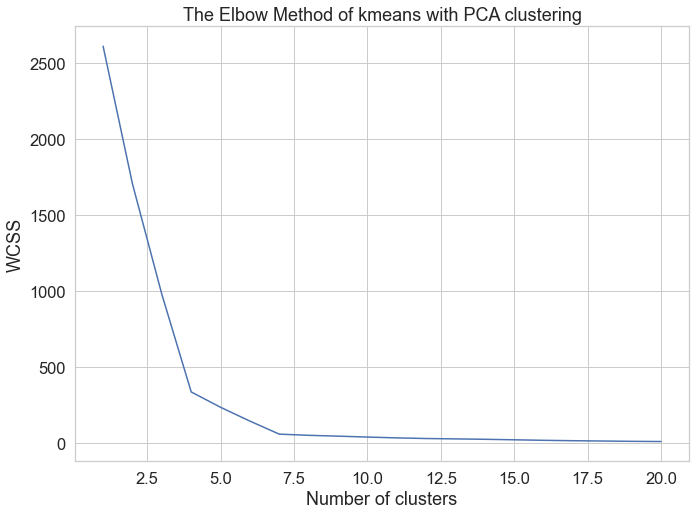

In [69]:
wcss=[]
for i in range (1,21):
    k_means_pca=KMeans(n_clusters=i,init='k-means++',random_state=42)
    k_means_pca.fit(scores_pca)
    wcss.append(k_means_pca.inertia_)
plt.plot(range(1,21),wcss)
plt.title('The Elbow Method of kmeans with PCA clustering')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Comme on peut le constater, il y a deux nombres de clusters interessants sur le k-means des données réduites: 4 et 7. On a déja tester pour 4 clusters le kmeans, nous allons maintenant le tester pour les 7 clusters.

c:\Users\UserAD\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\UserAD\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Component 2', ylabel='Component 1'>

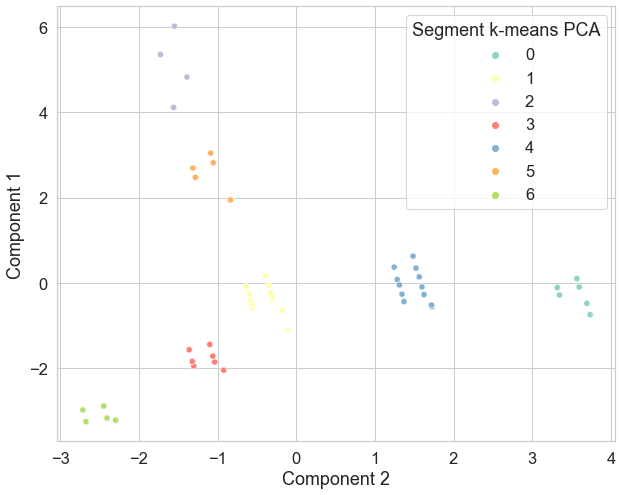

In [70]:

kmeans_pca=KMeans(n_clusters=7,init='k-means++',random_state=42)
kmeans_pca.fit(scores_pca)
df_segm_pca_kmeans7=pd.concat([scaled_features_df.reset_index(drop=True),
pd.DataFrame(scores_pca)],axis=1)
df_segm_pca_kmeans7.columns.values[-3:] = ['Component 1','Component 2','Component 3']
df_segm_pca_kmeans7['Segment k-means PCA'] = kmeans_pca.labels_
x_axis = df_segm_pca_kmeans7['Component 2']
y_axis = df_segm_pca_kmeans7['Component 1']
plt.figure(figsize =(10,8))
sns.scatterplot(x_axis,y_axis, hue= df_segm_pca_kmeans7['Segment k-means PCA'],
palette="Set3")

In [ ]:
#afficher les centroides

## Visualisation par T-SNE

c:\Users\UserAD\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='x', ylabel='y'>

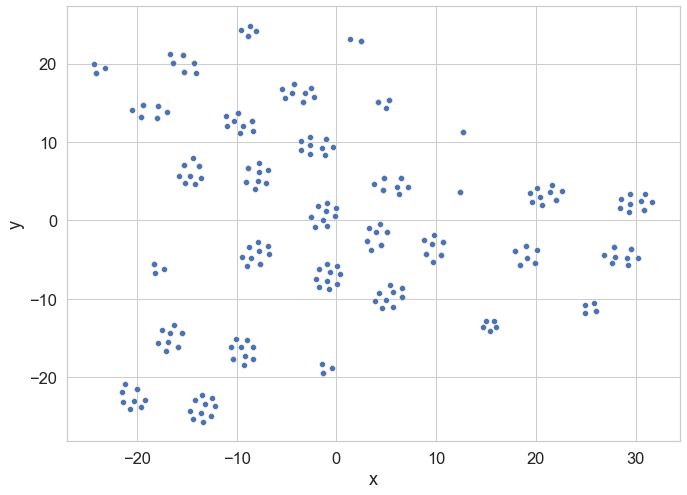

In [71]:
from sklearn.manifold import TSNE

tsne_df=scaled_features_df.copy()
m = TSNE(learning_rate=50)

tsne_features = m.fit_transform(tsne_df)

tsne_df['x']=tsne_features[:,0]
tsne_df['y']=tsne_features[:,1]


sns.scatterplot(x='x',y='y',data=tsne_df)



c:\Users\UserAD\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\UserAD\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='x', ylabel='y'>

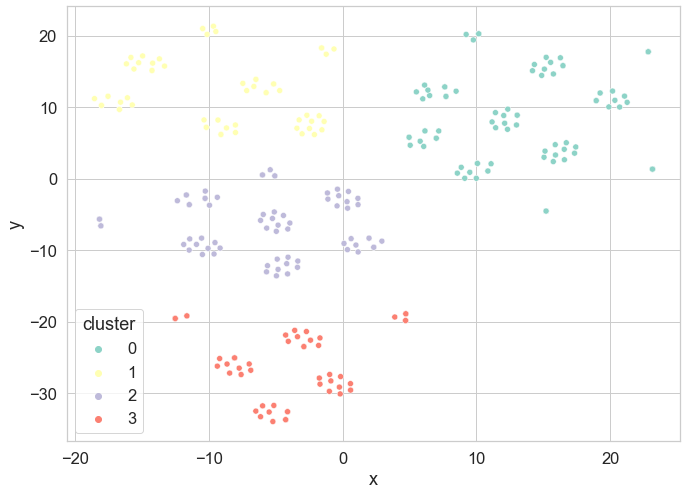

In [73]:
#essayons maintenant avec 4 clusters
kmeans=KMeans(n_clusters=4, max_iter=100, random_state=42)
kmeans.fit(scaled_features_df)
scaled_features_df['cluster']=kmeans.labels_
tsne_df=scaled_features_df.copy()
m = TSNE(learning_rate=50)

tsne_features = m.fit_transform(tsne_df)

tsne_df['x']=tsne_features[:,0]
tsne_df['y']=tsne_features[:,1]


sns.scatterplot(x='x',y='y',data=tsne_df,hue='cluster',palette="Set3")


c:\Users\UserAD\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\UserAD\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='x', ylabel='y'>

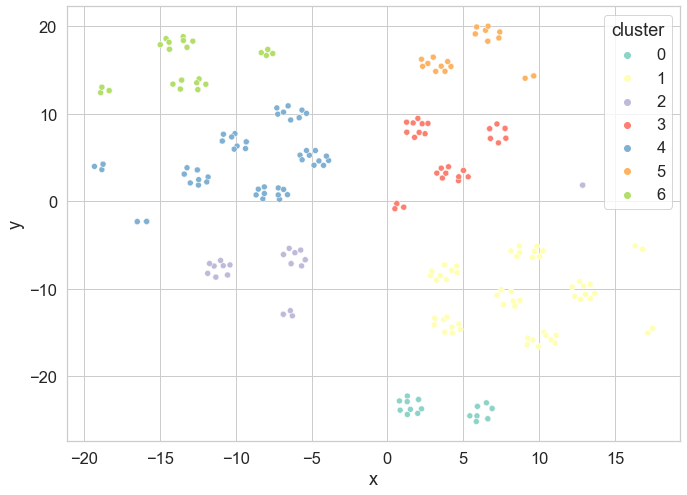

In [74]:
#essayons maintenant pour 7 clusters
kmeans=KMeans(n_clusters=7, max_iter=100, random_state=42)
kmeans.fit(scaled_features_df)
scaled_features_df['cluster']=kmeans.labels_
tsne_df=scaled_features_df.copy()
m = TSNE(learning_rate=50)

tsne_features = m.fit_transform(tsne_df)

tsne_df['x']=tsne_features[:,0]
tsne_df['y']=tsne_features[:,1]


sns.scatterplot(x='x',y='y',data=tsne_df,hue='cluster',palette="Set3")

D'apres tous les résultats précedents, on va maintenir 4 comme nombre de clusters.

## Catégorisation des clusters

In [114]:
dfe=preprocessing.StandardScaler().fit_transform(cat_dfe)
scaled_features_df = pd.DataFrame(dfe, index=cat_dfe.index, columns=cat_dfe.columns)
kmeans=KMeans(n_clusters=4, max_iter=100, random_state=0)
kmeans.fit(scaled_features_df)
scaled_features_df['cluster']=kmeans.labels_
category_df=scaled_features_df.copy()

c:\Users\UserAD\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [115]:
category_df.cluster.value_counts()

1    100
2     70
3     60
0     40
Name: cluster, dtype: int64

In [116]:
category_df['cluster']=category_df['cluster'].map({0:'first',1:'second',2:'third',3:'fourth'})

In [117]:
categories=category_df['cluster']
cat_df['categorie']=categories

In [118]:
cat_df.categorie.value_counts()

second    100
third      70
fourth     60
first      40
Name: categorie, dtype: int64

Nous allons maintenant essayer d'identifier ces differentes catégories selon leurs caractéristiques.

Text(0.5, 1.0, 'Distribution des prix par rapport à la catégorie')

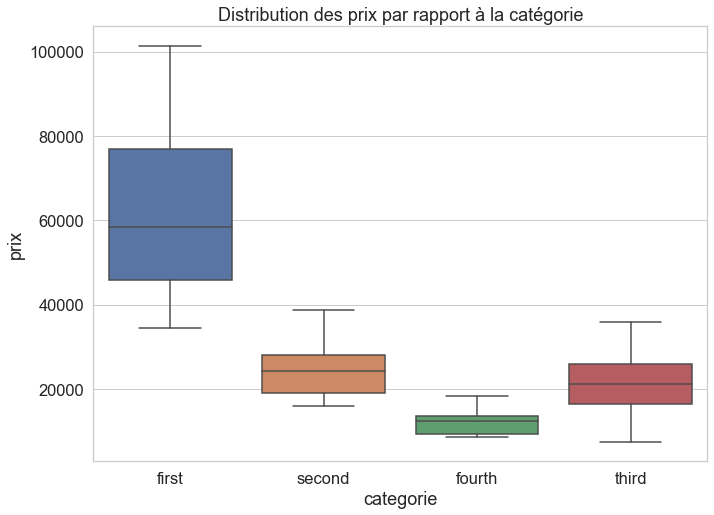

In [119]:
sns.set(rc={'figure.figsize':(11,8)}, font_scale=1.5, style='whitegrid')

sns.boxplot(x=cat_df['categorie'],y=cat_df['prix'])
plt.title('Distribution des prix par rapport à la catégorie')

Text(0.5, 1.0, 'Distribution de la puissance par rapport à la catégorie')

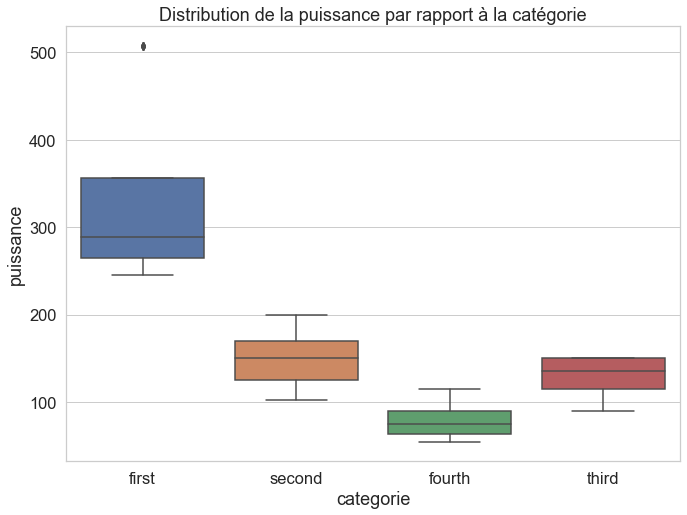

In [120]:
sns.set(rc={'figure.figsize':(11,8)}, font_scale=1.5, style='whitegrid')

sns.boxplot(x=cat_df['categorie'],y=cat_df['puissance'])
plt.title('Distribution de la puissance par rapport à la catégorie')

On peut remarquer que la catégorie first correspond aux voitures les plus chères et puissantes tandis que la catégorie fourth correspond aux voitures les moins cheres et les moins puissantes.

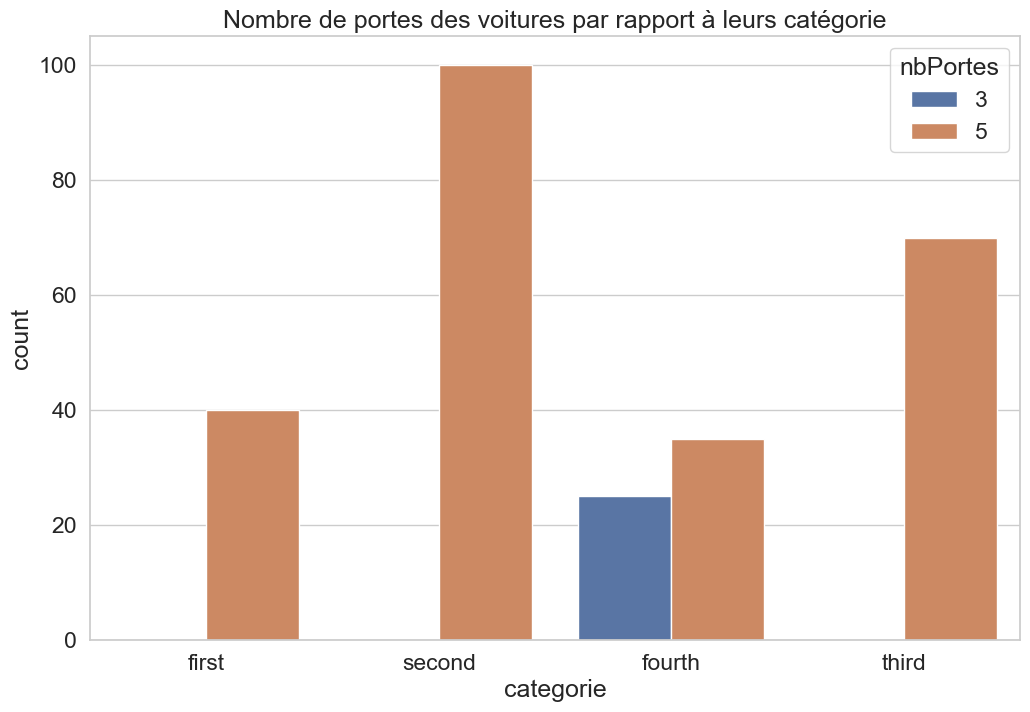

In [121]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
sns.countplot(x=cat_df.categorie,hue=cat_df.nbPortes, )
plt.title('Nombre de portes des voitures par rapport à leurs catégorie')
plt.show()


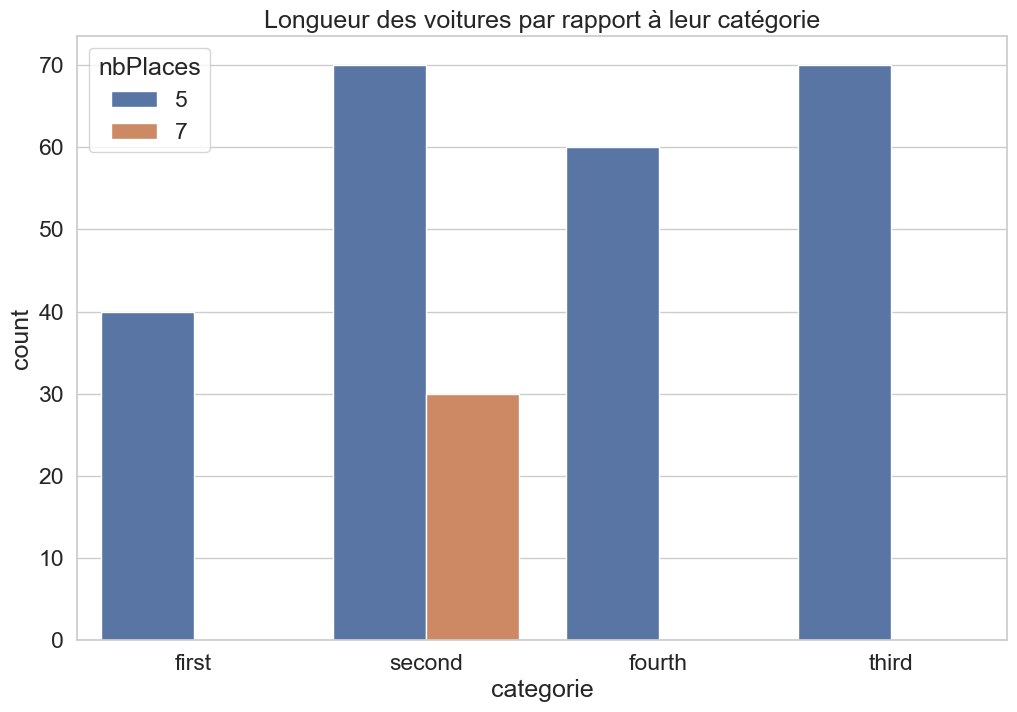

In [122]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
sns.countplot(x=cat_df.categorie,hue=cat_df.nbPlaces, )
plt.title('Longueur des voitures par rapport à leur catégorie')
plt.show()

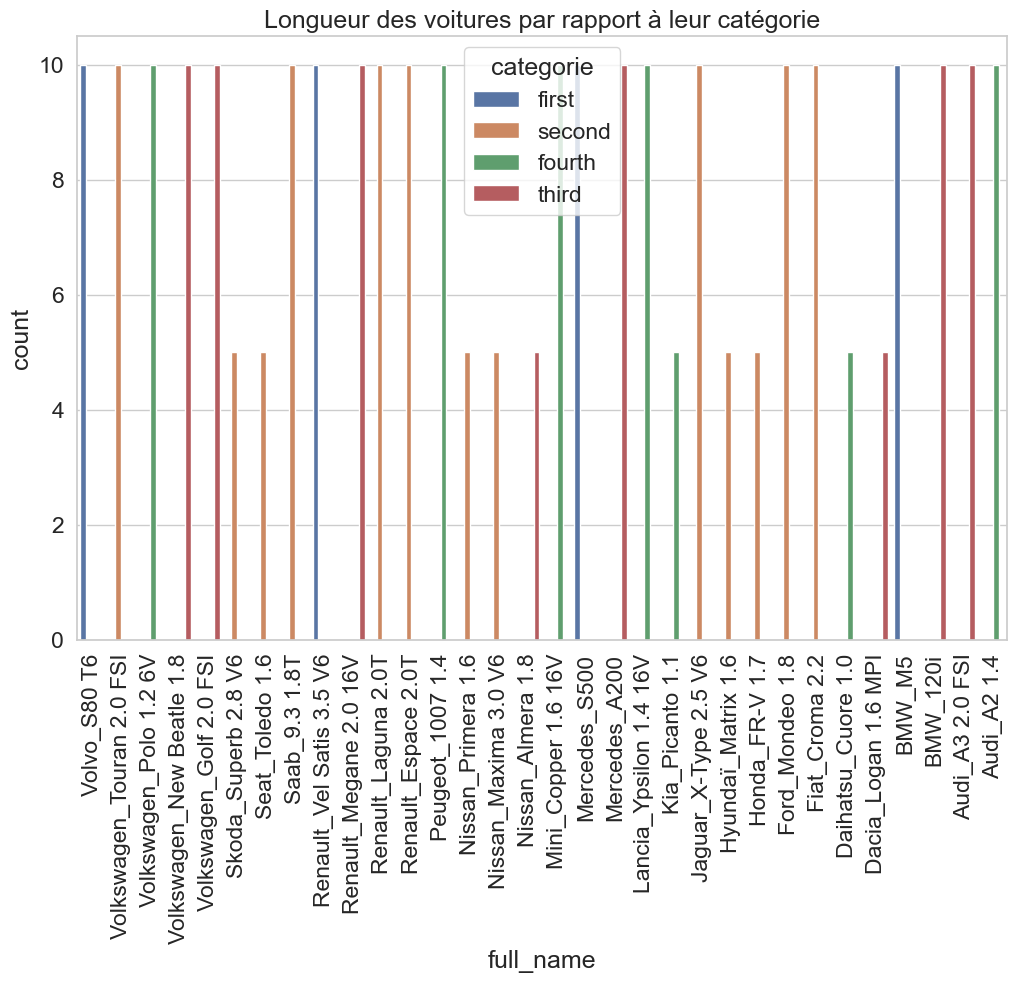

In [84]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
sns.countplot(x=cat_df.full_name,hue=cat_df.categorie )
plt.title('Longueur des voitures par rapport à leur catégorie')
plt.xticks(rotation=90)
plt.show()

## Hypothese 1 : 4 clusters

D'apres les modèles des voitures propres à chaque modèle, on va mettre les catégories suivantes:
- first: sportive
- second: familiale
- third: hatchback
- fourth: micro

In [123]:
cat_df['categorie']=cat_df['categorie'].map({'first':'sportive','second':'familiale','third':'hatchback','fourth':'micro'})

In [124]:
cat_df.head()

,puissance,longueur,nbPlaces,nbPortes,occasion,prix,full_name,categorie
0,272,très longue,5,5,0,50500,Volvo_S80 T6,sportive
1,272,très longue,5,5,0,50500,Volvo_S80 T6,sportive
2,272,très longue,5,5,0,50500,Volvo_S80 T6,sportive
3,272,très longue,5,5,1,35350,Volvo_S80 T6,sportive
4,272,très longue,5,5,1,35350,Volvo_S80 T6,sportive


In [125]:
categories4=cat_df['categorie']

In [126]:
new_df=pd.read_csv('Données_communes/Catalogue.csv',encoding='latin-1')

In [127]:
new_df['categorie']=categories4

In [128]:
new_df.tail()

,marque,nom,puissance,longueur,nbPlaces,nbPortes,couleur,occasion,prix,categorie
265,Audi,A2 1.4,75,courte,5,5,noir,False,18310,micro
266,Audi,A2 1.4,75,courte,5,5,rouge,False,18310,micro
267,Audi,A2 1.4,75,courte,5,5,blanc,True,12817,micro
268,Audi,A2 1.4,75,courte,5,5,rouge,True,12817,micro
269,Audi,A2 1.4,75,courte,5,5,blanc,False,18310,micro


In [129]:
new_df.to_csv('clustered/catalogue4.csv')

## Hypothèse 2 : 7 clusters

In [130]:
dfe=preprocessing.StandardScaler().fit_transform(cat_dfe)
scaled_features_df = pd.DataFrame(dfe, index=cat_dfe.index, columns=cat_dfe.columns)
kmeans=KMeans(n_clusters=7, max_iter=100, random_state=0)
kmeans.fit(scaled_features_df)
scaled_features_df['cluster']=kmeans.labels_
category_df=scaled_features_df.copy()

c:\Users\UserAD\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [131]:
category_df.cluster.value_counts()

1    65
5    60
3    50
6    35
2    30
0    25
4     5
Name: cluster, dtype: int64

In [138]:
categories=category_df['cluster']
cat_df['categorie']=categories

In [139]:
cat_df.categorie.value_counts()

1    65
5    60
3    50
6    35
2    30
0    25
4     5
Name: categorie, dtype: int64

Text(0.5, 1.0, 'Distribution des prix par rapport à la catégorie')

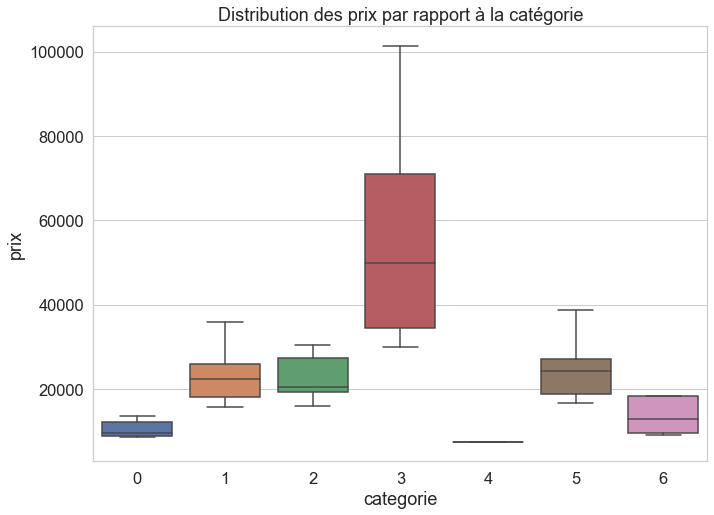

In [140]:
sns.set(rc={'figure.figsize':(11,8)}, font_scale=1.5, style='whitegrid')

sns.boxplot(x=cat_df['categorie'],y=cat_df['prix'])
plt.title('Distribution des prix par rapport à la catégorie')

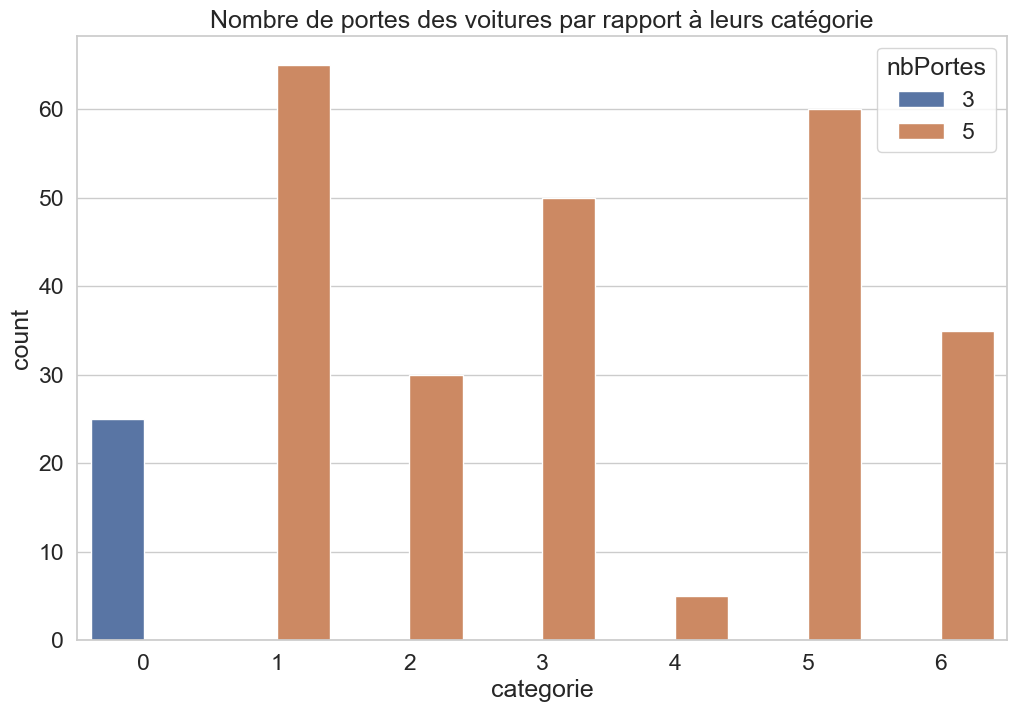

In [141]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
sns.countplot(x=cat_df.categorie,hue=cat_df.nbPortes, )
plt.title('Nombre de portes des voitures par rapport à leurs catégorie')
plt.show()

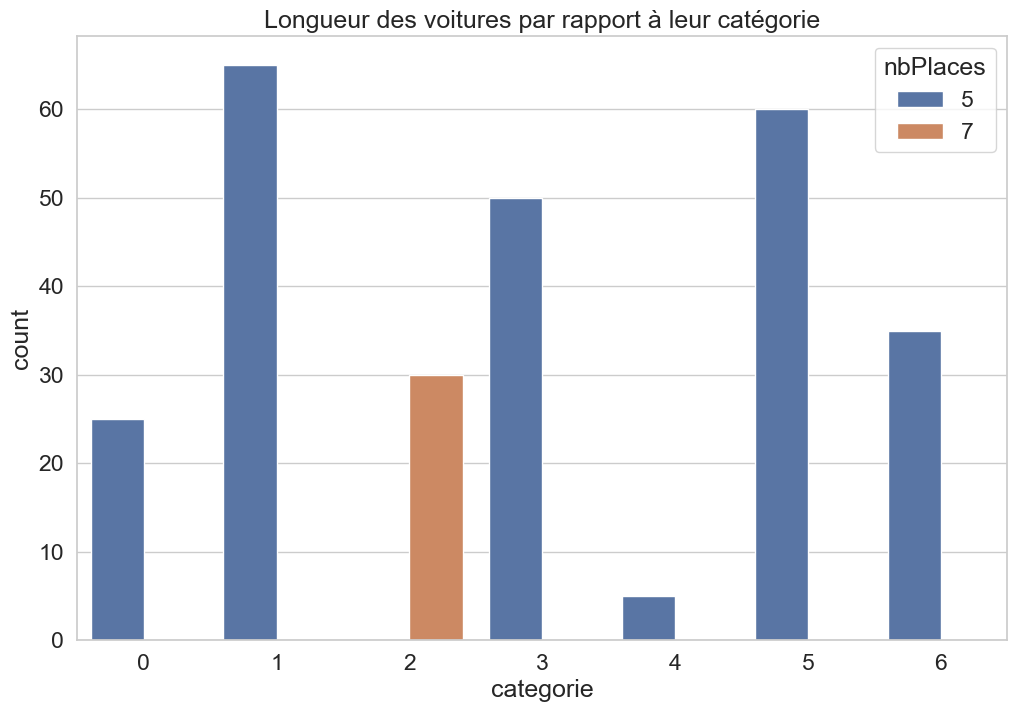

In [142]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
sns.countplot(x=cat_df.categorie,hue=cat_df.nbPlaces, )
plt.title('Longueur des voitures par rapport à leur catégorie')
plt.show()

Text(0.5, 1.0, 'Distribution de la puissance par rapport à la catégorie')

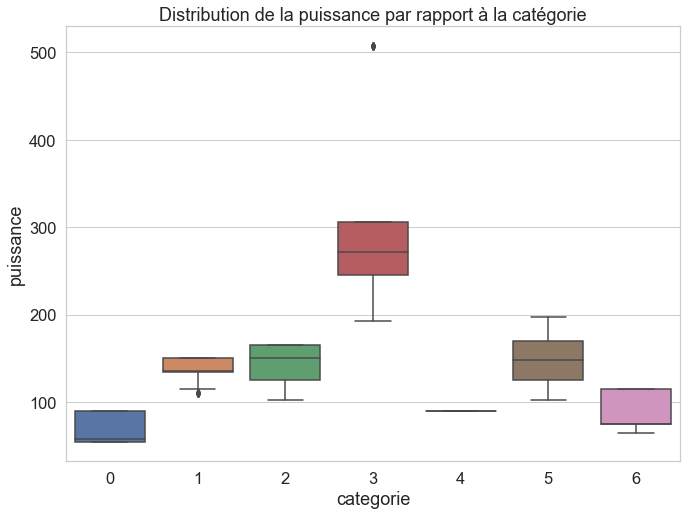

In [143]:
sns.set(rc={'figure.figsize':(11,8)}, font_scale=1.5, style='whitegrid')

sns.boxplot(x=cat_df['categorie'],y=cat_df['puissance'])
plt.title('Distribution de la puissance par rapport à la catégorie')

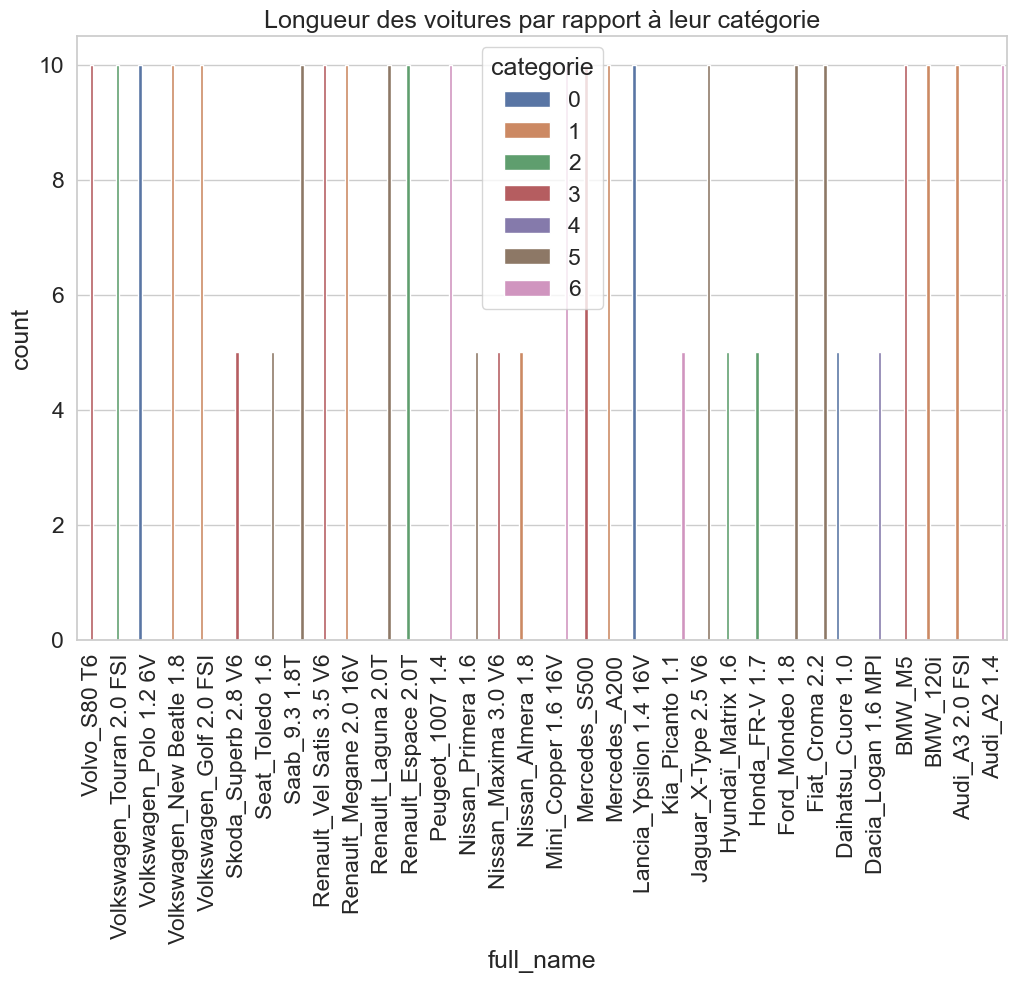

In [144]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
sns.countplot(x=cat_df.full_name,hue=cat_df.categorie )
plt.title('Longueur des voitures par rapport à leur catégorie')
plt.xticks(rotation=90)
plt.show()

In [150]:
for i in range(7):
    print("Categorie", i, ":",set(cat_df[cat_df['categorie']==i].full_name))
        

Categorie 0 : {'Lancia_Ypsilon 1.4 16V', 'Daihatsu_Cuore 1.0', 'Volkswagen_Polo 1.2 6V'}
Categorie 1 : {'Renault_Megane 2.0 16V', 'Volkswagen_New Beatle 1.8', 'Volkswagen_Golf 2.0 FSI', 'Mercedes_A200', 'Audi_A3 2.0 FSI', 'BMW_120i', 'Nissan_Almera 1.8'}
Categorie 2 : {'Renault_Espace 2.0T', 'Volkswagen_Touran 2.0 FSI', 'Hyundaï_Matrix 1.6', 'Honda_FR-V 1.7'}
Categorie 3 : {'Nissan_Maxima 3.0 V6', 'Renault_Vel Satis 3.5 V6', 'Volvo_S80 T6', 'Skoda_Superb 2.8 V6', 'BMW_M5', 'Mercedes_S500'}
Categorie 4 : {'Dacia_Logan 1.6 MPI'}
Categorie 5 : {'Renault_Laguna 2.0T', 'Ford_Mondeo 1.8', 'Fiat_Croma 2.2', 'Saab_9.3 1.8T', 'Seat_Toledo 1.6', 'Nissan_Primera 1.6', 'Jaguar_X-Type 2.5 V6'}
Categorie 6 : {'Peugeot_1007 1.4', 'Kia_Picanto 1.1', 'Audi_A2 1.4', 'Mini_Copper 1.6 16V'}


On retiendra les catégories suivantes:
- Catégorie 0: Micro
- Categorie 1: Hatchback
- Catégorie 2: Familiale
- Categorie 3: Sportive
- categorie 4+5: Berline
- Categorie 6: Petite Citadine

In [151]:
cat_df['categorie']=cat_df['categorie'].map({0:'Micro',1:'Hatchback',2:'Familiale',3:'Sportive',4:'Berline',5:'Berline',6:'Citadine'})

In [152]:
cat_df.categorie.value_counts()

Hatchback    65
Berline      65
Sportive     50
Citadine     35
Familiale    30
Micro        25
Name: categorie, dtype: int64

In [154]:
categories7=cat_df['categorie']
new_df=pd.read_csv('Données_communes/Catalogue.csv',encoding='latin-1')
new_df['categorie']=categories7
new_df.to_csv('clustered/catalogue7.csv')

In [4]:
immat_df=pd.read_csv('Données_communes/Immatriculations.csv',encoding='latin-1')

In [5]:
immat_df.shape

(2000000, 10)

In [6]:
cli1_df=pd.read_csv("Données_groupe/Groupe_TPT_1/Clients_11.csv", encoding='latin-1')
cli2_df=pd.read_csv("Données_groupe/Groupe_TPT_1/Clients_12.csv", encoding='latin-1')

In [7]:
cli_df=pd.concat([cli1_df,cli2_df])

In [8]:
cli_df.head()

,age,sexe,taux,situationFamiliale,nbEnfantsAcharge,2eme voiture,immatriculation
0,44,M,476,En Couple,0,false,3176 TS 67
1,20,M,422,En Couple,2,false,3721 QS 49
2,49,F,221,Célibataire,0,false,9099 UV 26
3,57,M,246,Célibataire,0,false,3563 LA 55
4,58,M,1149,Célibataire,0,false,6963 AX 34


In [9]:
cli_df.shape

(200000, 7)

In [10]:
new_df=pd.read_csv('clustered/catalogue7.csv')

In [11]:
df3=pd.merge(immat_df,new_df, left_on=['marque','nom','puissance','longueur','nbPlaces','nbPortes','couleur','occasion','prix'], right_on=['marque','nom','puissance','longueur','nbPlaces','nbPortes','couleur','occasion','prix'], how='left')
df3

,immatriculation,marque,nom,puissance,longueur,nbPlaces,nbPortes,couleur,occasion,prix,Unnamed: 0,categorie
0,3176 TS 67,Renault,Laguna 2.0T,170,longue,5,5,blanc,False,27300,99,Berline
1,3721 QS 49,Volvo,S80 T6,272,très longue,5,5,noir,False,50500,1,Sportive
2,9099 UV 26,Volkswagen,Golf 2.0 FSI,150,moyenne,5,5,gris,True,16029,41,Hatchback
3,3563 LA 55,Peugeot,1007 1.4,75,courte,5,5,blanc,True,9625,113,Citadine
4,6963 AX 34,Audi,A2 1.4,75,courte,5,5,gris,False,18310,262,Citadine
...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,771 CQ 78,Mercedes,S500,306,très longue,5,5,gris,True,70910,150,Sportive
1999996,8182 PL 97,Lancia,Ypsilon 1.4 16V,90,courte,5,3,blanc,True,9450,173,Micro
1999997,8550 AP 53,Ford,Mondeo 1.8,125,longue,5,5,rouge,False,23900,209,Berline
1999998,737 MK 20,Audi,A2 1.4,75,courte,5,5,bleu,True,12817,263,Citadine


In [12]:
final=pd.merge(cli_df,df3, left_on=['immatriculation'], right_on=['immatriculation'], how='left')
final.drop(['marque','nom','puissance','longueur','nbPlaces','nbPortes','couleur','occasion','prix'], inplace=True, axis=1)
final

,age,sexe,taux,situationFamiliale,nbEnfantsAcharge,2eme voiture,immatriculation,Unnamed: 0,categorie
0,44,M,476,En Couple,0,false,3176 TS 67,99,Berline
1,20,M,422,En Couple,2,false,3721 QS 49,1,Sportive
2,49,F,221,Célibataire,0,false,9099 UV 26,41,Hatchback
3,57,M,246,Célibataire,0,false,3563 LA 55,113,Citadine
4,58,M,1149,Célibataire,0,false,6963 AX 34,262,Citadine
...,...,...,...,...,...,...,...,...,...
200665,40,Féminin,1000,Célibataire,0,false,8108 RO 11,266,Citadine
200666,21,Femme,235,Célibataire,0,false,7268 LO 18,118,Citadine
200667,64,M,179,En Couple,0,false,9059 XM 27,4,Sportive
200668,71,M,836,Célibataire,0,false,9945 TN 57,156,Hatchback


In [13]:
final.drop(['immatriculation','Unnamed: 0'], inplace=True, axis=1)


In [14]:
final.head()

,age,sexe,taux,situationFamiliale,nbEnfantsAcharge,2eme voiture,categorie
0,44,M,476,En Couple,0,false,Berline
1,20,M,422,En Couple,2,false,Sportive
2,49,F,221,Célibataire,0,false,Hatchback
3,57,M,246,Célibataire,0,false,Citadine
4,58,M,1149,Célibataire,0,false,Citadine


## traitement des données

In [15]:
final.isnull().value_counts()

age    sexe   taux   situationFamiliale  nbEnfantsAcharge  2eme voiture  categorie
False  False  False  False               False             False         False        200670
dtype: int64

In [16]:
final['2eme voiture'].value_counts()

false    174183
true      26062
            216
?           209
Name: 2eme voiture, dtype: int64

In [17]:
final.describe()

,age,sexe,taux,situationFamiliale,nbEnfantsAcharge,2eme voiture,categorie
count,200670,200670,200670,200670,200670,200670,200670
unique,70,9,1003,9,8,4,5
top,19,M,576,En Couple,0,false,Sportive
freq,5085,137305,560,128428,90298,174183,67749


In [18]:
final['2eme voiture'].replace('?','false',inplace=True)

In [19]:
final['2eme voiture'].replace(' ','false',inplace=True)

In [20]:
final['2eme voiture'].value_counts()

false    174608
true      26062
Name: 2eme voiture, dtype: int64

In [21]:
final['2eme voiture']=final['2eme voiture'].map({'true':1,'false':0})

In [22]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200670 entries, 0 to 200669
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   age                 200670 non-null  object
 1   sexe                200670 non-null  object
 2   taux                200670 non-null  object
 3   situationFamiliale  200670 non-null  object
 4   nbEnfantsAcharge    200670 non-null  object
 5   2eme voiture        200670 non-null  int64 
 6   categorie           200670 non-null  object
dtypes: int64(1), object(6)
memory usage: 12.2+ MB


In [23]:
final.situationFamiliale.value_counts()

En Couple      128428
Célibataire     59828
Seule            9813
Marié(e)         1278
Seul              581
?                 221
N/D               210
                  196
Divorcée          115
Name: situationFamiliale, dtype: int64

In [24]:
final.situationFamiliale.replace('?','N/D',inplace=True)
final.situationFamiliale.replace(' ','N/D',inplace=True)

In [25]:
final.situationFamiliale.value_counts()

En Couple      128428
Célibataire     59828
Seule            9813
Marié(e)         1278
N/D               627
Seul              581
Divorcée          115
Name: situationFamiliale, dtype: int64

In [26]:
final.taux = pd.to_numeric(final.taux, errors='coerce')


In [27]:
final[final.taux.isna()==True]

,age,sexe,taux,situationFamiliale,nbEnfantsAcharge,2eme voiture,categorie
104,42,M,NaN,Seule,2,0,Sportive
105,26,M,NaN,Célibataire,0,0,Berline
407,56,M,NaN,En Couple,3,0,Sportive
1069,32,F,NaN,En Couple,2,0,Sportive
1736,39,M,NaN,En Couple,3,0,Sportive
...,...,...,...,...,...,...,...
199830,73,F,NaN,Célibataire,0,0,Hatchback
199836,65,F,NaN,Célibataire,0,0,Hatchback
200104,20,F,NaN,Célibataire,0,0,Hatchback
200151,28,F,NaN,En Couple,2,0,Berline


In [28]:
final.taux=final.taux.fillna(final.taux.mean())

In [29]:
final[final.taux.isna()==True]

,age,sexe,taux,situationFamiliale,nbEnfantsAcharge,2eme voiture,categorie


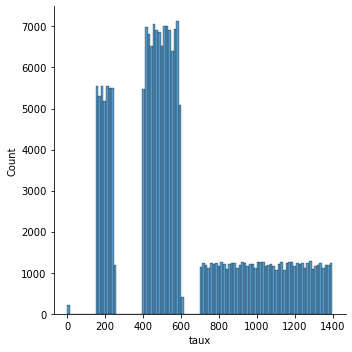

In [30]:
sns.displot(final.taux,kind='hist')

In [31]:
final.nbEnfantsAcharge.value_counts()

0     90298
1     33169
2     32846
3     23611
4     20166
-1      202
?       189
        189
Name: nbEnfantsAcharge, dtype: int64

In [32]:
final.nbEnfantsAcharge=final.nbEnfantsAcharge.replace('-1',0)
final.nbEnfantsAcharge=final.nbEnfantsAcharge.replace('?',0)
final.nbEnfantsAcharge=final.nbEnfantsAcharge.replace(' ',0)
final.nbEnfantsAcharge=final.nbEnfantsAcharge.replace(0,'0')

In [33]:
final.nbEnfantsAcharge.value_counts()

0    90878
1    33169
2    32846
3    23611
4    20166
Name: nbEnfantsAcharge, dtype: int64

In [34]:
final.sexe.value_counts()

M           137305
F            58770
Masculin      1440
Homme         1391
Femme          631
Féminin        551
               209
?              198
N/D            175
Name: sexe, dtype: int64

In [35]:
final.sexe=final.sexe.map({'M':0,'F':1,'Masculin':0,'Homme':0,'Femme':1,'Féminin':1})
final.sexe.value_counts()

0.0    140136
1.0     59952
Name: sexe, dtype: int64

In [36]:
final.sexe = pd.to_numeric(final.sexe, errors='coerce')


In [37]:
final.sexe.value_counts()

0.0    140136
1.0     59952
Name: sexe, dtype: int64

In [38]:
final.sexe=final.sexe.fillna(0)

In [39]:
final.sexe.value_counts()

0.0    140718
1.0     59952
Name: sexe, dtype: int64

c:\Users\UserAD\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sexe', ylabel='count'>

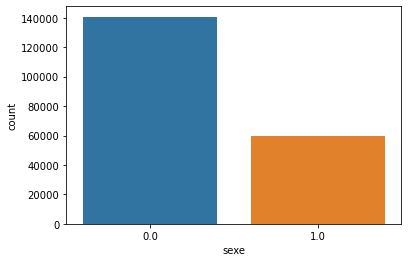

In [40]:
sns.countplot(final.sexe)

In [41]:
final.age=pd.to_numeric(final.age,errors='coerce')

In [42]:
final.age=final.age.fillna(final.age.mean())

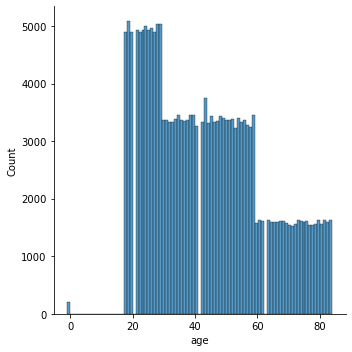

In [43]:
sns.displot(final.age,kind='hist')

In [44]:
final.age=final.age.replace(-1,final.age.mean())

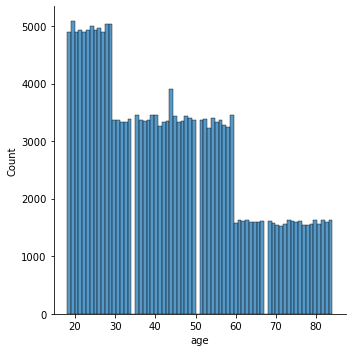

In [45]:
sns.displot(final.age,kind='hist')

In [46]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200670 entries, 0 to 200669
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   age                 200670 non-null  float64
 1   sexe                200670 non-null  float64
 2   taux                200670 non-null  float64
 3   situationFamiliale  200670 non-null  object 
 4   nbEnfantsAcharge    200670 non-null  object 
 5   2eme voiture        200670 non-null  int64  
 6   categorie           200670 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 16.3+ MB


In [51]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.compose import ColumnTransformer
categorical=['situationFamiliale','nbEnfantsAcharge']
numeric_features=['age','sexe','taux','2eme voiture']
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

In [63]:
from sklearn.model_selection import train_test_split

# sets of columns to be transformed different ways


y = final['categorie']
X = final.drop(columns=['categorie'])


# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.2,random_state=7)

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipeline = Pipeline(steps=[
('ohe_and_scaling', column_transformer),
('clf',LogisticRegression(solver='liblinear'))
    ])
logreg=pipeline.fit(X_train,y_train)

In [65]:
logreg.score(X_train,y_train)

0.6979742861414262

In [66]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

scores_accuracy = cross_val_score(logreg, X, y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(logreg, X, y, cv=10, scoring='neg_log_loss')
scores_auc = cross_val_score(logreg, X, y, cv=10, scoring='roc_auc')

print('K-fold cross-validation results:')
print(logreg.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())
print(logreg.__class__.__name__+" average log_loss is %2.3f" % -scores_log_loss.mean())
print(logreg.__class__.__name__+" average auc is %2.3f" % scores_auc.mean())

c:\Users\UserAD\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\UserAD\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\UserAD\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "c:\Users\UserAD\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 352, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
c:\Users\UserAD\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan

K-fold cross-validation results:
Pipeline average accuracy is 0.698
Pipeline average log_loss is 0.630
Pipeline average auc is nan


c:\Users\UserAD\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\UserAD\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\UserAD\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "c:\Users\UserAD\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 352, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


In [70]:
# Read in the data
import pandas as pd
# Scale the data
from sklearn.preprocessing import StandardScaler
# Pipeline, Gridsearch, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
# Plot the confusion matrix at the end of the tutorial
from sklearn.metrics import plot_confusion_matrix
# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm

ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\UserAD\anaconda3\lib\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "C:\Users\UserAD\anaconda3\lib\site-packages\pip\_vendor\urllib3\response.py", line 519, in read
    data = self._fp.read(amt) if not fp_closed else b""
  File "C:\Users\UserAD\anaconda3\lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 62, in read
    data = self.__fp.read(amt)
  File "C:\Users\UserAD\anaconda3\lib\http\client.py", line 462, in read
    n = self.readinto(b)
  File "C:\Users\UserAD\anaconda3\lib\http\client.py", line 506, in readinto
    n = self.fp.readinto(b)
  File "C:\Users\UserAD\anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "C:\Users\UserAD\anaconda3\lib\ssl.py", line 1241, in recv_into
    return self.read(nbytes, buffer)
  File "C:\Users\UserAD\anaconda3\lib\ssl.py", line 1099, in read
    return self._sslobj.read(len, buf